In [28]:
import pandas as pd
from skimpy import skim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from neuralforecast import NeuralForecast
from mlforecast import MLForecast
from statsforecast.models import Naive, SeasonalNaive, SimpleExponentialSmoothing, RandomWalkWithDrift
from statsforecast import StatsForecast
from neuralforecast.models import LSTM, GRU, NBEATS, TFT, MLP

# -----------------------------------------------
# Day 15: Defining classical ML time series models
# -----------------------------------------------

In [7]:
def prepare_and_clean_frames(master_df, post_code, housing_type):

    master_df['datesold'] = master_df['datesold'].apply(lambda x: pd.to_datetime(x))

    master_df['datesold_year'] = master_df['datesold'].apply(lambda x: x.year)
    master_df['datesold_month'] = master_df['datesold'].apply(lambda x: x.month)
    master_df['datesold_day'] = master_df['datesold'].apply(lambda x: x.day)
    
    unit_code = master_df[(master_df['postcode'] == post_code) & (master_df['propertyType'] == housing_type)].sort_values('datesold')

    unit_code_final = unit_code.groupby(['datesold_year', 'datesold_month']).agg({
    'postcode':pd.Series.mode, 'price':'sum', 'propertyType':pd.Series.mode, 'bedrooms':'sum', 
    }).reset_index()

    unit_code_final['full_date'] = pd.to_datetime(
        unit_code_final['datesold_year'].astype(str) + '-' + unit_code_final['datesold_month'].astype(str) + '-01'
        )
    unit_code_final['price/bedroom'] = unit_code_final['price']/unit_code_final['bedrooms']

    unit_code_final = unit_code_final.drop(['datesold_year', 'datesold_month','price', 'bedrooms'], axis=1)

    date_range = pd.date_range(start=unit_code_final['full_date'].min(), end=unit_code_final['full_date'].max(), freq='MS')
    missing_dates = date_range.difference(unit_code_final['full_date'])

    missing_df = pd.DataFrame({
        'postcode':post_code,
        'propertyType':housing_type,
        'full_date': missing_dates,
        'price/bedroom':np.nan
    })

    full_data = pd.concat([missing_df,unit_code_final]).sort_values('full_date')

    full_data['price/bedroom'] = full_data['price/bedroom'].ffill()

    return full_data


In [8]:
def run_BaselineForecast(df):

    df_NIXTLA = pd.DataFrame({
        'unique_id':0,
        'ds': df['full_date'],
        'y': df['price/bedroom']
    })
    
    models = [Naive(), RandomWalkWithDrift(), SimpleExponentialSmoothing(alpha=.8)]
    model_dict = {
        'Naive': Naive(),
        'RWD': RandomWalkWithDrift(),
        'SES': SimpleExponentialSmoothing(alpha=.8),
    }

    model = StatsForecast(
        df=df_NIXTLA,
        models=models,
        freq='MS',
        n_jobs=-1
    )

    df_cv = model.cross_validation(
        df=df_NIXTLA,
        step_size=3,
        h=3,
        n_windows=3
    )

    final_models = []
    max_error = 10e10
    for col in df_cv.columns[3:]:
        error = mean_absolute_error(df_cv['y'], df_cv[col])
        if error < max_error:
            max_error = error
            best_model = col
    
    model_func = model_dict[best_model]
    errors_on_best = df_cv[['ds', 'y', best_model]]
    trained_model = model.fit(df_NIXTLA)

    kwargs = {
        'ts':df_NIXTLA,
        'model':trained_model,
        'model_sig':best_model,
        'cv_df':df_cv,
        'cv_selected':errors_on_best
    }
    
    return kwargs



In [25]:
def run_MLForecast(df):

    df_NIXTLA = pd.DataFrame({
        'unique_id':0,
        'ds': df['full_date'],
        'y': df['price/bedroom']
    })
    
    models = [XGBRegressor(), RandomForestRegressor(), LinearRegression()]
    model_dict = {
        'XGBRegressor': XGBRegressor(),
        'RandomForestRegressor': RandomForestRegressor(),
        'LinearRegression': LinearRegression(),
    }

    model = MLForecast(
        models=models,
        lags = [1,2,3,4,5,6],
        freq='MS'
    )

    df_cv = model.cross_validation(
        df=df_NIXTLA,
        h=8,
        n_windows=3
    )

    final_models = []
    max_error = 10e10
    for col in df_cv.columns[4:]:
        error = mean_absolute_error(df_cv['y'], df_cv[col])
        if error < max_error:
            max_error = error
            best_model = col
    
    model_func = model_dict[best_model]
    errors_on_best = df_cv[['ds', 'y', best_model]]
    trained_model = model.fit(df_NIXTLA)

    kwargs = {
        'ts':df_NIXTLA,
        'model':trained_model,
        'model_sig':best_model,
        'cv_df':df_cv,
        'cv_selected':errors_on_best
    }
    
    return kwargs



In [27]:
def run_NeuralForecast(df):

    df_NIXTLA = pd.DataFrame({
        'unique_id':0,
        'ds': df['full_date'],
        'y': df['price/bedroom']
    })
    
    models = [TFT(), NBEATS(), MLP()]
    model_dict = {
        'TFT': TFT(),
        'NBEATS': NBEATS(),
        'MLP': MLP(),
    }

    model = MLForecast(
        models=models,
        lags = [1,2,3,4,5,6],
        freq='MS'
    )

    df_cv = model.cross_validation(
        df=df_NIXTLA,
        h=8,
        n_windows=3
    )

    final_models = []
    max_error = 10e10
    for col in df_cv.columns[4:]:
        error = mean_absolute_error(df_cv['y'], df_cv[col])
        if error < max_error:
            max_error = error
            best_model = col
    
    model_func = model_dict[best_model]
    errors_on_best = df_cv[['ds', 'y', best_model]]
    trained_model = model.fit(df_NIXTLA)

    kwargs = {
        'ts':df_NIXTLA,
        'model':trained_model,
        'model_sig':best_model,
        'cv_df':df_cv,
        'cv_selected':errors_on_best
    }
    
    return kwargs



In [5]:
df = pd.read_csv('raw_sales.csv')
all_postcodes = df['postcode'].unique()
housing_type_1 = 'unit'
housing_type_2 = 'house'

ts_sets = []

In [10]:
tester = prepare_and_clean_frames(df, all_postcodes[0], housing_type='house')

In [26]:
unit_test = run_MLForecast(tester)

Index(['unique_id', 'ds', 'cutoff', 'y', 'XGBRegressor',
       'RandomForestRegressor', 'LinearRegression'],
      dtype='object')


In [96]:
def plot_ts(df):
    code = df['postcode'].values[0]
    property_type = df['propertyType'].values[0]
    plt.plot(df['full_date'], df['price/bedroom'])
    plt.title(f'Price/Bedroom vs. Date Sold for Post Code {code} and Housing Type {property_type}')
    plt.xlabel('Date Sold')
    plt.ylabel('Price/Bedroom')

In [4]:
df = pd.read_csv('raw_sales.csv')
all_postcodes = df['postcode'].unique()
housing_type_1 = 'unit'
housing_type_2 = 'house'

ts_sets = []

In [91]:
for code in all_postcodes:
    try:
        code_house = prepare_and_clean_frames(df, code, 'house')
        code_unit = prepare_and_clean_frames(df, code, 'unit')
        data_dict = {code:[code_house, code_unit]}
    except:
        data_dict = 'NOT ENOUGH DATA'

    ts_sets.append(data_dict)

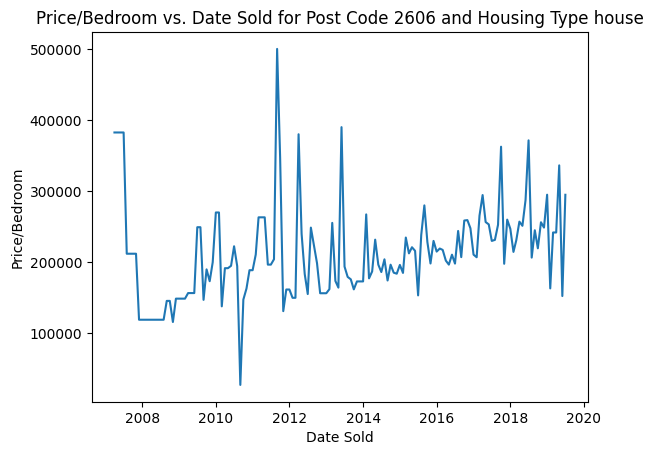

In [97]:
plot_ts(prepare_and_clean_frames(df, all_postcodes[3], 'house'))